#  Pytorch-卷積運作與參數生成
 
 本課程主旨在介紹深度學習中卷積神經網路(Convolutional neural network, CNN)在pytorch的卷積(convolution, Conv.)運算相關的知識，包含<br> 
 <font size=4>
1. Conv.的參數設定<br>
2. Conv.怎麼運算<br>
3. Conv.權重如何生成<br>
4. 權重那要用哪生成方式<br>

Note: 此課程介紹的皆以2D卷積為主。
    
下圖取自我部落格文章[卷積神經網路(Convolutional neural network, CNN) — CNN運算流程](https://chih-sheng-huang821.medium.com/%E5%8D%B7%E7%A9%8D%E7%A5%9E%E7%B6%93%E7%B6%B2%E8%B7%AF-convolutional-neural-network-cnn-cnn%E9%81%8B%E7%AE%97%E6%B5%81%E7%A8%8B-ecaec240a631)的圖片
    
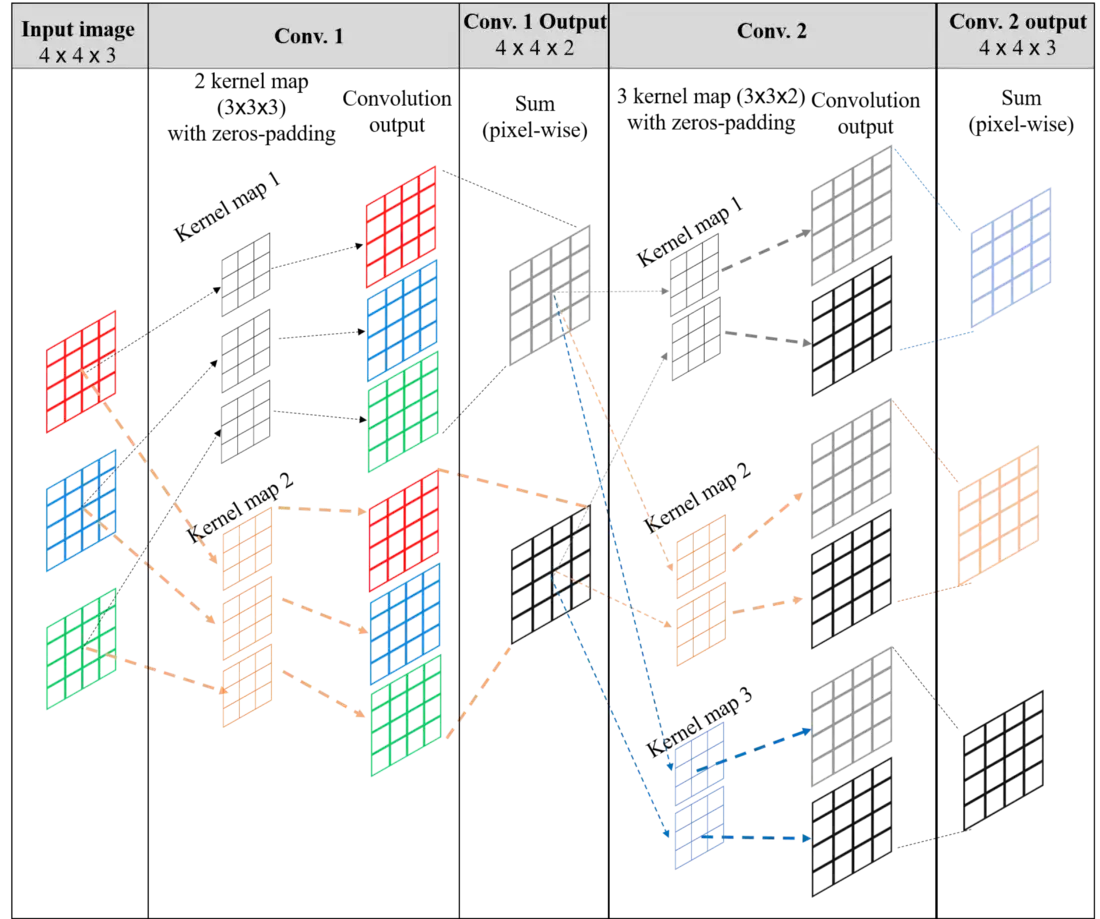

此範例為兩層的卷積，輸入為(長*寬*channel)<br>
輸入(channel=3) → Conv.1(channel=2) → Conv.2(channel=3)
 
>**卷積神經網路基本上就是利用訓練資料和目標函數在找Kernel maps的數字(權重)應該是多少?**<br>

我們開始細數介紹在pytorch上跟Conv.相關的所有介紹。

## 1. Conv.的參數設定

我們先看一下pytorch內[nn.Conv2D](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)的參數定義
```
torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
```
>pytorch的2D Conv.要輸入的資料是$(N, C_{in}, H, W)$，輸出則是$(N, C_{out}, H_{out}, W_{out})$<br>
$N$: Batch size<br>
$C$: Channel size<br>
$H$: 特徵圖的高(單位Pixel)<br>
$W$: 特徵圖的寬(單位Pixel)<br>


參數設定的項目有<br>
```in_channels```: $ C_{in}$ 輸入特徵圖的channel數。<br>
```out_channels```: $ C_{out}$ 輸出特徵圖的channel數。 <br>
```kernel_size```: 卷積的kernel大小。<br>
```stride=1```: 步伐大小，如果為1代表kernel map步伐一次移動一個pixel，為2代表kernel map步伐一次移動兩個pixel。<br>
```padding```: 輸入圖是否需要生出額外的邊(元素皆為0)。<br>
```dilation```: atrous convolution空洞卷積設定。<br>
```groups```: Group convolution設定，將輸入和輸出的channel進行分組，```in_channels```和```out_channels```必須要能被```groups```整除。且當in_channels=out_channels=groups就是depthwise Conv.<br> 
```bias```: 輸出的channel需要bias嗎? True(default) or False。<br> 




<font size=3>**範例1:bias有沒有設定的差異** </font>

| Example   | # input channel | # output channel | kernel sizse | bias   |
| :-----:   | :----:          | :----:           |   :----:     | :----: | 
| Example 1 |  1              |  2               |   3          |  0     |
| Example 2 |  1              |  2               |   3          |  1     |


In [1]:
import torch
import torch.nn as nn
import numpy as np
conv = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1)
print('- Weight of conv layer:\n\t{}'.format(conv.weight))
print('- Weight(shape) of conv layer:{}'.format(conv.weight.shape))
print('+ Bias of conv layer:\n\t{}'.format(conv.bias))
print('+ Bias(shape) of conv layer:{}'.format(conv.bias.shape))

- Weight of conv layer:
	Parameter containing:
tensor([[[[ 0.2955, -0.1519, -0.0677],
          [ 0.0117, -0.2607,  0.3183],
          [ 0.2084, -0.3311,  0.0155]]],


        [[[-0.2354, -0.1724,  0.0610],
          [-0.1379,  0.2939,  0.2297],
          [-0.0637,  0.3183, -0.0139]]]], requires_grad=True)
- Weight(shape) of conv layer:torch.Size([2, 1, 3, 3])
+ Bias of conv layer:
	Parameter containing:
tensor([0.3228, 0.0517], requires_grad=True)
+ Bias(shape) of conv layer:torch.Size([2])


In [2]:
conv = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1, bias=False)
print('- Weight of conv layer:\n\t{}'.format(conv.weight))
print('- Weight(shape) of conv layer:{}'.format(conv.weight.shape))
print('+ Bias of conv layer:\n\t{}'.format(conv.bias))

- Weight of conv layer:
	Parameter containing:
tensor([[[[ 0.0225, -0.2054, -0.1621],
          [ 0.1299,  0.2871,  0.2658],
          [-0.1420, -0.1580, -0.0576]]],


        [[[ 0.3136, -0.2499,  0.1335],
          [ 0.3052,  0.0042,  0.3153],
          [ 0.1213,  0.2221,  0.1665]]]], requires_grad=True)
- Weight(shape) of conv layer:torch.Size([2, 1, 3, 3])
+ Bias of conv layer:
	None


<font size=3>**範例2: Input channel和output channel都增加** </font>

| Example   | # input channel | # output channel | kernel sizse | bias   |
| :-----:   | :----:          | :----:           |   :----:     | :----: | 
| Example 1 |  2              |  2               |   3          |  0     |
| Example 2 |  2              |  3               |   3          |  0     |


In [3]:
conv = nn.Conv2d(in_channels=2, out_channels=2, kernel_size=3, stride=1, bias=False)
print('- Weight of conv layer:\n\t{}'.format(conv.weight))
print('- Weight(shape) of conv layer:{}'.format(conv.weight.shape))
print('+ Bias of conv layer:\n\t{}'.format(conv.bias))

- Weight of conv layer:
	Parameter containing:
tensor([[[[-0.2284, -0.0013,  0.2050],
          [-0.2084, -0.2103,  0.0816],
          [-0.1262, -0.0999, -0.1222]],

         [[-0.2197,  0.0686, -0.1917],
          [ 0.0424,  0.0460,  0.0472],
          [ 0.1326, -0.1764,  0.2308]]],


        [[[ 0.0226,  0.0057,  0.1110],
          [-0.1241,  0.1085,  0.2120],
          [-0.0860, -0.1800, -0.0515]],

         [[ 0.0801, -0.0304, -0.1816],
          [-0.0408,  0.1190,  0.0631],
          [ 0.2092,  0.1240,  0.0731]]]], requires_grad=True)
- Weight(shape) of conv layer:torch.Size([2, 2, 3, 3])
+ Bias of conv layer:
	None


In [4]:
conv = nn.Conv2d(in_channels=2, out_channels=3, kernel_size=3, stride=1, bias=False)
print('- Weight of conv layer:\n\t{}'.format(conv.weight))
print('- Weight(shape) of conv layer:{}'.format(conv.weight.shape))

- Weight of conv layer:
	Parameter containing:
tensor([[[[-0.2264, -0.1518,  0.0572],
          [ 0.0826, -0.0887,  0.1097],
          [-0.0820, -0.2165,  0.2172]],

         [[ 0.1036,  0.1054, -0.0937],
          [-0.0106,  0.1337, -0.1254],
          [-0.1731, -0.1774,  0.1178]]],


        [[[-0.2147, -0.2168,  0.1688],
          [-0.1591,  0.2269,  0.0056],
          [-0.0489, -0.0283, -0.2319]],

         [[ 0.0889,  0.0570, -0.0058],
          [ 0.0344, -0.1153, -0.2122],
          [-0.1845, -0.1865,  0.1030]]],


        [[[ 0.1606, -0.1456, -0.2127],
          [-0.2354, -0.1040,  0.0940],
          [-0.1904,  0.1790,  0.1473]],

         [[ 0.1002, -0.0993, -0.1977],
          [ 0.1361,  0.2266, -0.0008],
          [-0.2305,  0.1300,  0.0192]]]], requires_grad=True)
- Weight(shape) of conv layer:torch.Size([3, 2, 3, 3])


從上面大量的範例可以看到卷積Conv.2D的weight擺放方式是<br>
$$channel_{output} \times channel_{input} \times ks \times ks$$

<font color='red' size=3>**Note: Conv除了方形，也可以為長方形的型態**</font>

In [5]:
conv = nn.Conv2d(in_channels=2, out_channels=3, kernel_size=(3,1), stride=1, bias=False)
print(conv.weight.shape)
conv = nn.Conv2d(in_channels=2, out_channels=3, kernel_size=(3,2), stride=1, bias=False)
print(conv.weight.shape)

torch.Size([3, 2, 3, 1])
torch.Size([3, 2, 3, 2])


### Conv權重除了隨機生成之外，也是可以自己指定參數的

<frot size=3>
    剛剛我們用conv.weight可以看到權重值，所以看的到就能指定值進去。<br>
    但不是直接塞到conv.weight，因為是class參數(torch.nn.parameter.Parameter)，不是torch.tensor<br>
    因此需塞到的位置是conv.weight.data (屬性為torch.tensor)<br>
    同樣要改bias，也是去改conv.同樣要改bias.data<br>
    </font>

In [6]:
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1)
print('weight of conv layer:\n{}'.format(conv.weight))
print('bias of conv layer:\n{}'.format(conv.bias))

weight of conv layer:
Parameter containing:
tensor([[[[-0.3078, -0.1358, -0.0351],
          [ 0.2676,  0.1268, -0.2569],
          [-0.2129,  0.2278,  0.0251]]]], requires_grad=True)
bias of conv layer:
Parameter containing:
tensor([0.2518], requires_grad=True)


In [7]:
replace_weight = torch.tensor([[0,0,0],
                               [1,2,3],
                               [4,5,6]])
replace_bias = torch.tensor([10000000000000])
conv.weight.data=replace_weight
conv.bias.data=replace_bias
print('weight of conv layer:\n{}'.format(conv.weight))
print('bias of conv layer:\n{}'.format(conv.bias))

weight of conv layer:
Parameter containing:
tensor([[0, 0, 0],
        [1, 2, 3],
        [4, 5, 6]], requires_grad=True)
bias of conv layer:
Parameter containing:
tensor([10000000000000], requires_grad=True)


<font color=#0000FF size=3> **快速將權重改成全部都是0、全部都是1或是任意數**
</font>

In [8]:
conv.weight.data.zero_()
conv.bias.data.zero_()
print('weight of conv layer:\n{}'.format(conv.weight))
print('bias of conv layer:\n{}'.format(conv.bias))

weight of conv layer:
Parameter containing:
tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]], requires_grad=True)
bias of conv layer:
Parameter containing:
tensor([0], requires_grad=True)


In [9]:
conv.weight.data.fill_(1)
conv.bias.data.fill_(1)
print('*'*50)
print('weight of conv layer:\n{}'.format(conv.weight))
print('bias of conv layer:\n{}'.format(conv.bias))
######################################
conv.weight.data.fill_(0)
conv.bias.data.fill_(0)
print('*'*50)
print('weight of conv layer:\n{}'.format(conv.weight))
print('bias of conv layer:\n{}'.format(conv.bias))
######################################
conv.weight.data.fill_(200)
conv.bias.data.fill_(10)
print('*'*50)
print('weight of conv layer:\n{}'.format(conv.weight))
print('bias of conv layer:\n{}'.format(conv.bias))

**************************************************
weight of conv layer:
Parameter containing:
tensor([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]], requires_grad=True)
bias of conv layer:
Parameter containing:
tensor([1], requires_grad=True)
**************************************************
weight of conv layer:
Parameter containing:
tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]], requires_grad=True)
bias of conv layer:
Parameter containing:
tensor([0], requires_grad=True)
**************************************************
weight of conv layer:
Parameter containing:
tensor([[200, 200, 200],
        [200, 200, 200],
        [200, 200, 200]], requires_grad=True)
bias of conv layer:
Parameter containing:
tensor([10], requires_grad=True)


# 2. Conv.怎麼運算

**Example 1**: <br>
<font size = 3>Conv. 單一channel輸入，單一輸出.

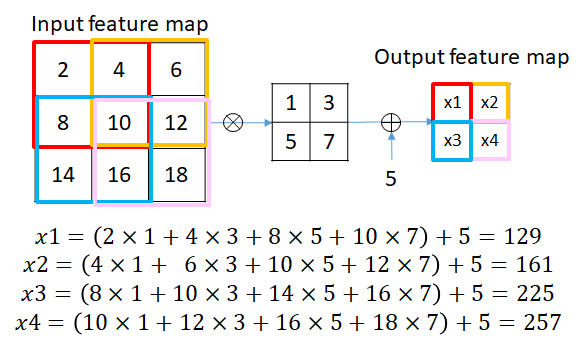

In [10]:
InputImage = torch.FloatTensor([[ 2, 4, 6],
                                [ 8,10,12],
                                [14,16,18]]).unsqueeze(axis=0).unsqueeze(axis=0) # 1,1,2,2

conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2, stride=1)
replace_weight = torch.FloatTensor([[1,3],
                                    [5,7]]).unsqueeze(axis=0).unsqueeze(axis=0) # 1,1,2,2
replace_bias = torch.tensor([5])
conv.weight.data=replace_weight
conv.bias.data=replace_bias
print('Input feature map:{}'.format(InputImage))
print('weight of conv.:{}'.format(conv.weight.data))
print('bias of conv.:{}'.format(conv.bias.data))
output = conv(InputImage)
print('Output feature map:{}'.format(output))


Input feature map:tensor([[[[ 2.,  4.,  6.],
          [ 8., 10., 12.],
          [14., 16., 18.]]]])
weight of conv.:tensor([[[[1., 3.],
          [5., 7.]]]])
bias of conv.:tensor([5])
Output feature map:tensor([[[[129., 161.],
          [225., 257.]]]], grad_fn=<ThnnConv2DBackward>)


**Example 2**: <br>
<font size = 3>Conv. 兩個channel輸入，兩個channel輸出.
    
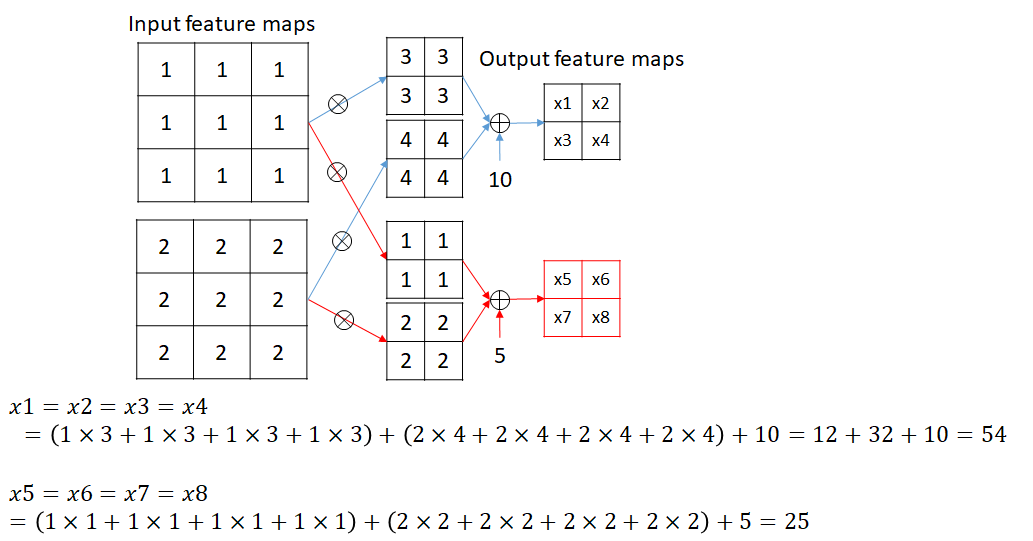

In [11]:
InputImage = torch.FloatTensor([
                                [[ 1,1,1],
                                 [ 1,1,1],
                                 [ 1,1,1]],
                                [[ 2,2,2],
                                 [ 2,2,2],
                                 [ 2,2,2]]
                                ]).unsqueeze(axis=0) # 1*2*3*3

conv = nn.Conv2d(in_channels=2, out_channels=2, kernel_size=2, stride=1) # 2*2*2*2
replace_weight = torch.FloatTensor([
                                    [[[3,3],
                                     [3,3]],
                                    [[4,4],
                                     [4,4]]],
                                    [[[1,1],
                                     [1,1]],
                                    [[2,2],
                                     [2,2]]]
                                    ])
replace_bias = torch.tensor([10,5])
conv.weight.data=replace_weight
conv.bias.data=replace_bias
print('Input feature map:{}'.format(InputImage))
print('weight of conv.:{}'.format(conv.weight.data))
print('bias of conv.:{}'.format(conv.bias.data))
output = conv(InputImage)
print('Output feature map:{}'.format(output))


Input feature map:tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[2., 2., 2.],
          [2., 2., 2.],
          [2., 2., 2.]]]])
weight of conv.:tensor([[[[3., 3.],
          [3., 3.]],

         [[4., 4.],
          [4., 4.]]],


        [[[1., 1.],
          [1., 1.]],

         [[2., 2.],
          [2., 2.]]]])
bias of conv.:tensor([10,  5])
Output feature map:tensor([[[[54., 54.],
          [54., 54.]],

         [[25., 25.],
          [25., 25.]]]], grad_fn=<ThnnConv2DBackward>)


## 3. Conv.權重如何生成

利用內建函數將Conv.權重指定為某種/特定分布<br>

預設是權重初始值是從均勻分布生成`

(array([19., 15., 21., 19., 21., 13., 25., 20., 19., 26., 26., 15., 14.,
        13., 19., 31., 21., 26., 28., 18., 16., 19., 26., 16., 19., 16.,
        18., 22., 19., 18., 19., 21., 19., 19., 26., 33., 23., 26., 24.,
        12., 18., 17., 15., 21., 15., 16., 16., 24., 23., 15.]),
 array([-3.16112004e-02, -3.03466879e-02, -2.90821753e-02, -2.78176628e-02,
        -2.65531503e-02, -2.52886377e-02, -2.40241252e-02, -2.27596126e-02,
        -2.14951001e-02, -2.02305876e-02, -1.89660750e-02, -1.77015625e-02,
        -1.64370500e-02, -1.51725365e-02, -1.39080239e-02, -1.26435114e-02,
        -1.13789989e-02, -1.01144863e-02, -8.84997379e-03, -7.58546079e-03,
        -6.32094825e-03, -5.05643571e-03, -3.79192294e-03, -2.52741040e-03,
        -1.26289774e-03,  1.61491334e-06,  1.26612757e-03,  2.53064022e-03,
         3.79515276e-03,  5.05966553e-03,  6.32417807e-03,  7.58869061e-03,
         8.85320362e-03,  1.01177162e-02,  1.13822287e-02,  1.26467412e-02,
         1.39112538e-02,  1.5175

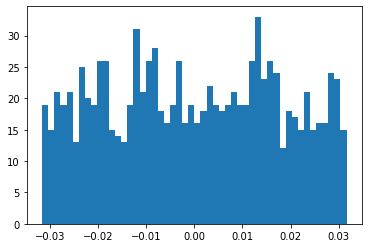

In [12]:
import matplotlib.pyplot as plt
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1000,1), stride=1)
data = conv.weight.data
plt.hist(np.squeeze(data.numpy()),50)

Example 1: 常態分布(Normal Distribution) $N(0,1)$

In [13]:
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3), stride=1)
print('weight of conv layer:\n{}'.format(conv.weight))
print('*'*50)
conv.weight.data.normal_(0,1)
print('weight of conv layer:\n{}'.format(conv.weight))


weight of conv layer:
Parameter containing:
tensor([[[[-0.0863,  0.1998,  0.2673],
          [ 0.2281, -0.1071,  0.1783],
          [ 0.0099,  0.2287,  0.0534]]]], requires_grad=True)
**************************************************
weight of conv layer:
Parameter containing:
tensor([[[[-0.3358, -0.5335,  0.7813],
          [ 0.5229, -0.8187,  0.9784],
          [-0.3718,  0.1866, -0.6776]]]], requires_grad=True)


(array([ 1.,  0.,  1.,  0.,  1.,  3.,  5.,  4.,  3., 11., 12., 12., 15.,
        21., 21., 27., 24., 35., 38., 43., 59., 53., 43., 35., 42., 60.,
        61., 46., 44., 51., 48., 25., 34., 26., 21., 18., 15., 11.,  9.,
         3.,  6.,  5.,  0.,  3.,  1.,  2.,  1.,  0.,  0.,  1.]),
 array([-3.2564802 , -3.1237383 , -2.9909964 , -2.8582544 , -2.7255125 ,
        -2.5927706 , -2.4600286 , -2.3272867 , -2.1945448 , -2.0618029 ,
        -1.9290609 , -1.796319  , -1.6635771 , -1.5308352 , -1.3980932 ,
        -1.2653513 , -1.1326094 , -0.99986744, -0.8671255 , -0.7343836 ,
        -0.60164165, -0.46889973, -0.3361578 , -0.20341587, -0.07067394,
         0.06206799,  0.19480991,  0.32755184,  0.46029377,  0.5930357 ,
         0.7257776 ,  0.85851955,  0.9912615 ,  1.1240034 ,  1.2567453 ,
         1.3894873 ,  1.5222292 ,  1.6549711 ,  1.787713  ,  1.920455  ,
         2.053197  ,  2.1859388 ,  2.3186808 ,  2.4514227 ,  2.5841646 ,
         2.7169065 ,  2.8496485 ,  2.9823904 ,  3.1151323 ,

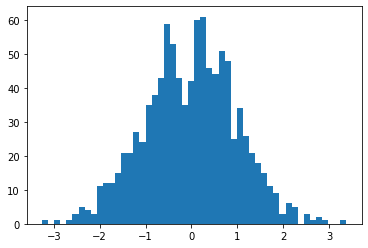

In [14]:
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1000,1), stride=1)
conv.weight.data.normal_(0,1)
data = conv.weight.data
data = data.numpy()
data = np.squeeze(data)
plt.hist(data,50)

## 4. 權重那要用哪生成方式

<font  size=3>
+ 1. 不用理他，用default就好 <br>
+ 2. Xavier系列: Xavier均匀分布、Xavier常態分布 <br>
+ 3. kaiming系列: kaiming均匀分布、kaiming常態分布 <br>
+ 4. 我要自己發明，但有哪些函數可以用

>Note:<br>
    - 參數初始化可以見torch.nn.init。 <br>
    - 均勻分布 = uniform distribution <br>
    - 常態分布 = normal distribution <br>
    有興趣知道為什麼要這樣設定的可以看我以前寫的文章[深度學習: Weight initialization和Batch Normalization](https://chih-sheng-huang821.medium.com/%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92-weight-initialization%E5%92%8Cbatch-normalization-f264c4be37f5)
    </font>

In [15]:
def histforConv(conv):
    data = conv.weight.data
    data = torch.flatten(data)
    plt.hist(np.squeeze(data.numpy()),50)
    plt.show()

### + 1. 不用理他，用default就好 <br>
Default用什麼生成，我們來看一下他的生成方式。

default是用均勻分布
$$U(-stdv, stdv)$$
stdv為
$$
stdv = \frac{1}{\sqrt{x}}
$$
x=(output channel個數*kernel sizse)

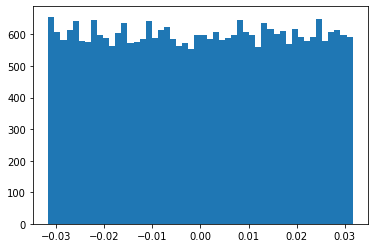

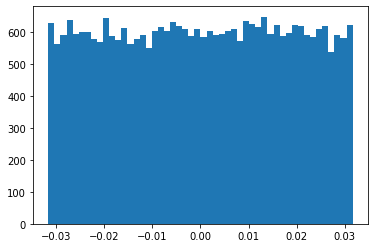

In [16]:
import math
conv = nn.Conv2d(in_channels=10, out_channels=30, kernel_size=(10,10), stride=1) # 30,10,10,10
histforConv(conv)

stdv = 1. / math.sqrt(conv.weight.size(1)*conv.weight.size(2)*conv.weight.size(3))
conv.weight.data.uniform_(-stdv, stdv)
histforConv(conv)


### +2. Xavier系列: Xavier均匀分布、Xavier常態分布

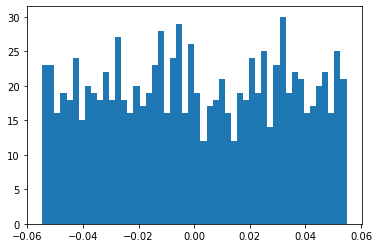

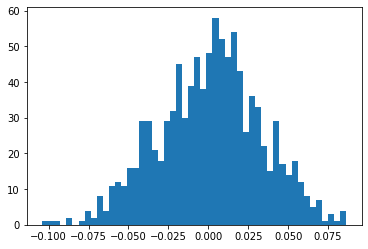

In [17]:
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1000,1), stride=1)
nn.init.xavier_uniform_(conv.weight)
histforConv(conv)

nn.init.xavier_normal_(conv.weight)
histforConv(conv)

也靠參數(gain)設定可以調整分布的範圍

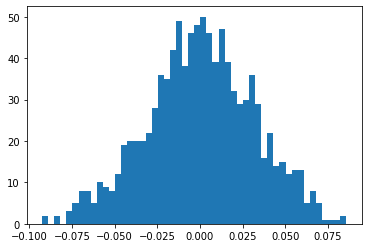

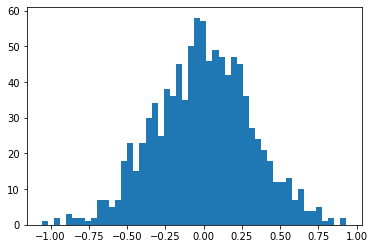

In [18]:
nn.init.xavier_normal_(conv.weight)
histforConv(conv)
nn.init.xavier_normal_(conv.weight, gain=10)
histforConv(conv)

### +3. kaiming系列: kaiming均匀分布、kaiming常態分布 <br>

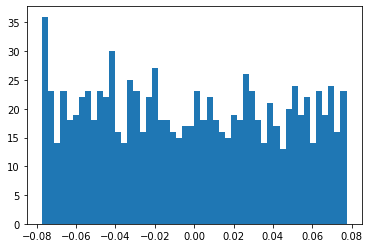

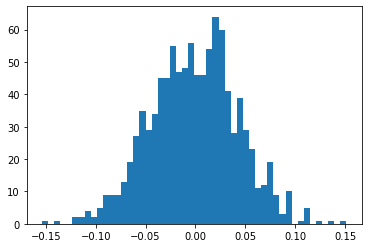

In [19]:
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1000,1), stride=1)
nn.init.kaiming_uniform_(conv.weight)
histforConv(conv)

nn.init.kaiming_normal_(conv.weight)
histforConv(conv)

### +4. 我要自己發明，但有哪些函數可以用<br>

Reference: [TORCH.NN.INIT](https://pytorch.org/docs/stable/nn.init.html?highlight=nn%20init%20sparse_#torch.nn.init.sparse_)

----------------
1. 均勻分布，參數服從均勻分布a到b之間: <br>
$$
U(a,b)
$$
<code>torch.nn.init.uniform_(tensor, a=0, b=1)</code>

----------------    
2. 常態分布，參數服從常態分布，default為平均數0 標準差1: <br>
$$
N(mean,std)
$$
<code>torch.nn.init.normal_(tensor, mean=0, std=1)</code>  

----------------    
3. 設定為常數 <br>
<code>torch.nn.init.constant_(tensor, val)</code>

----------------
4. 單位化矩陣設定 <br>
<code>torch.nn.init.eye_(tensor)</code>

----------------
5. 正交 <br>
讓生成的權重之間會正交。（必須至少是2維的，對於更高維度的張量，超出的維度會被展平，視作行等於第一個維度。<br>
<code>torch.nn.init.orthogonal_(tensor, gain=1)</code>

----------------
6. sparsity <br>
讓參數生成的時候會稀疏化。
參數sparsity設定為每一列要設定為0的比例。<br>
其他非0的參數生成採用$N(0, std)$，預設std=0.01。<br>
<code>torch.nn.init.sparse_(tensor, sparsity, std=0.01)</code>

----------------

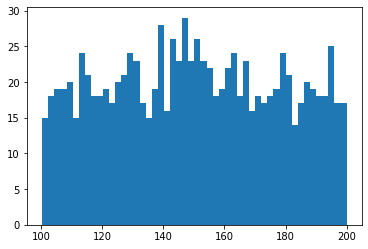

In [20]:
# 1. 均勻分布，參數服從均勻分布a到b之間
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1000,1), stride=1)
nn.init.uniform_(conv.weight,a=100, b=200)
histforConv(conv)

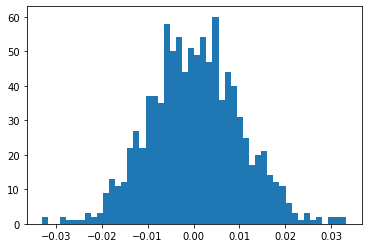

In [21]:
# 2. 常態分布，參數服從常態分布，default為平均數0 標準差1
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1000,1), stride=1)
nn.init.normal_(conv.weight,mean=0, std=0.01)
histforConv(conv)

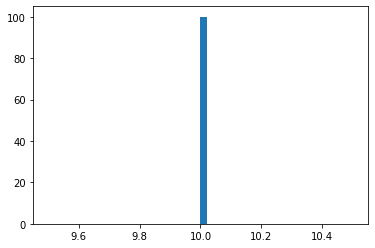

In [22]:
# 3. 設定為常數
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(100,1), stride=1)
nn.init.constant_(conv.weight,val=10)
histforConv(conv)

In [23]:
# 4. 單位化矩陣設定
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(5,5), stride=1)
nn.init.eye_(conv.weight.data[0,0,:,:])
print('weight of conv layer:\n{}'.format(conv.weight))

weight of conv layer:
Parameter containing:
tensor([[[[1., 0., 0., 0., 0.],
          [0., 1., 0., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.],
          [0., 0., 0., 0., 1.]]]], requires_grad=True)


In [24]:
# 5. 正交 
conv = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(2,1), stride=1)
nn.init.orthogonal_(conv.weight)
print('weight of conv layer:\n{}'.format(conv.weight))

data = conv.weight.data
print(data.shape)
data = data.numpy()[:,0,:,0]
print(np.dot(data,np.transpose(data)))


conv = nn.Conv2d(in_channels=10, out_channels=4, kernel_size=(1,1), stride=1)
nn.init.orthogonal_(conv.weight)
data = conv.weight.data
print(data.shape)
data = data.numpy()[:,:,0,0]
print(np.dot(data,np.transpose(data)))


weight of conv layer:
Parameter containing:
tensor([[[[-0.7493],
          [ 0.6623]]],


        [[[ 0.6623],
          [ 0.7493]]]], requires_grad=True)
torch.Size([2, 1, 2, 1])
[[9.999999e-01 7.129256e-08]
 [7.129256e-08 1.000000e+00]]
torch.Size([4, 10, 1, 1])
[[ 9.9999988e-01  3.7745316e-08  1.2014393e-08 -2.3293765e-08]
 [ 3.7745316e-08  1.0000000e+00 -1.5633473e-08 -9.5799688e-09]
 [ 1.2014393e-08 -1.5633473e-08  1.0000000e+00  1.3885448e-08]
 [-2.3293765e-08 -9.5799688e-09  1.3885448e-08  9.9999988e-01]]


In [25]:
# 6. sparsity 
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(5,5), stride=1)
nn.init.sparse_(conv.weight.data[0,0,:,:], sparsity=0.3, std=10)
print('weight of conv layer:\n{}'.format(conv.weight))

weight of conv layer:
Parameter containing:
tensor([[[[  9.1124,   0.0000,  22.7076, -17.3006,   5.8026],
          [-10.8578,  -1.5217,   0.0000,   0.0000,   7.6291],
          [  0.0000, -15.3814,  -7.1043,  -7.4126,   0.0000],
          [ -1.4954,   4.5001,  13.9835,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  -2.8287, -15.6034]]]],
       requires_grad=True)



## 作者 Author
![image](https://user-images.githubusercontent.com/25295252/204134360-67946cc4-e3fe-4c73-a994-b84e5e4098af.png)
<span> - &copy; 黃志勝 Chih-Sheng (Tommy) Huang (<a href="https://github.com/TommyHuang821">Github</a>) (<a href="https://sites.google.com/site/chihshenghuang821">個人網頁</a>) (<a href="https://medium.com/@chih-sheng-huang821">Medium文章</a>) </span>  

## Pytorch Tutorial 實作課程系列文章
## 目錄 
  * [Class 0: 數據型態簡介<br>](https://github.com/TommyHuang821/PytorchTutorial#class-0-%E6%95%B8%E6%93%9A%E5%9E%8B%E6%85%8B%E7%B0%A1%E4%BB%8B)
  * [Class 1: 資料庫取得 <br>](https://github.com/TommyHuang821/PytorchTutorial#class-1-%E8%B3%87%E6%96%99%E5%BA%AB%E5%8F%96%E5%BE%97-)
  * [Class 2: 利用Pytorch建立Dataset和Dataloader<br>](https://github.com/TommyHuang821/PytorchTutorial#class-2-%E5%88%A9%E7%94%A8pytorch%E5%BB%BA%E7%AB%8Bdataset%E5%92%8Cdataloader)
  * [Class 3: 利用Pytorch進行梯度下降更新<br>](https://github.com/TommyHuang821/PytorchTutorial#class-3-%E5%88%A9%E7%94%A8pytorch%E9%80%B2%E8%A1%8C%E6%A2%AF%E5%BA%A6%E4%B8%8B%E9%99%8D%E6%9B%B4%E6%96%B0)
  * [Class 4: 在pytorch建立卷積、池化和激活函數和自定義運算架構方式<br>](https://github.com/TommyHuang821/PytorchTutorial#class-4-%E5%9C%A8pytorch%E5%BB%BA%E7%AB%8B%E5%8D%B7%E7%A9%8D%E6%B1%A0%E5%8C%96%E5%92%8C%E6%BF%80%E6%B4%BB%E5%87%BD%E6%95%B8%E5%92%8C%E8%87%AA%E5%AE%9A%E7%BE%A9%E9%81%8B%E7%AE%97%E6%9E%B6%E6%A7%8B%E6%96%B9%E5%BC%8F)
  * [Class 5: 利用Pytorch模組torchvision進行資料擴增(Data Augmentation)<br>](https://github.com/TommyHuang821/PytorchTutorial#class-5-%E5%88%A9%E7%94%A8pytorch%E6%A8%A1%E7%B5%84torchvision%E9%80%B2%E8%A1%8C%E8%B3%87%E6%96%99%E6%93%B4%E5%A2%9Edata-augmentation)
  * [Class 6: Pytorch進行圖像分類模型訓練<br>](https://github.com/TommyHuang821/PytorchTutorial#class-6-pytorch%E9%80%B2%E8%A1%8C%E5%9C%96%E5%83%8F%E5%88%86%E9%A1%9E%E6%A8%A1%E5%9E%8B%E8%A8%93%E7%B7%B4)
  * [Class 7: Pytorch進行圖像分類 - 手刻ResNet-18和Torchvision匯入<br>](https://github.com/TommyHuang821/PytorchTutorial#class-7-pytorch%E9%80%B2%E8%A1%8C%E5%9C%96%E5%83%8F%E5%88%86%E9%A1%9E---%E6%89%8B%E5%88%BBresnet-18%E5%92%8Ctorchvision%E5%8C%AF%E5%85%A5)
  * [Class 8: Pytorch-AutoEncoder<br>](https://github.com/TommyHuang821/PytorchTutorial#class-8-pytorch-autoencoder)
  * [Class 9: Generative Adversarial Network(GAN)<br>](https://github.com/TommyHuang821/PytorchTutorial#class-9-generative-adversarial-networkgan)


## 授權 License
<a rel="license" href="https://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/3.0/tw/88x31.png" /></a> (CC BY-NC-SA 4.0)<br />本教學課程適用 <a rel="license" href="https://creativecommons.org/licenses/by-nc-sa/4.0/">Attribution-NonCommercial-ShareAlike 4.0 International</a> 授權方式。

※ 轉載、改作、分享請附上以下內容：
 - 如有轉載、改作、分享，請註明出處，source: https://github.com/TommyHuang821/PytorchTutorial
